## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from   sklearn.preprocessing   import MinMaxScaler
from   sklearn.model_selection import train_test_split
from   keras.models            import Sequential
from   keras.layers            import Dense
from   keras.layers            import LSTM
from   keras.layers            import Dropout
from   keras.callbacks         import EarlyStopping
from   keras.models            import load_model

## Load Data

In [2]:
hr_file = "data/heart-rate-time-series.csv"
hr_data = pd.read_csv(hr_file, header=None)

## Heart rate diagram

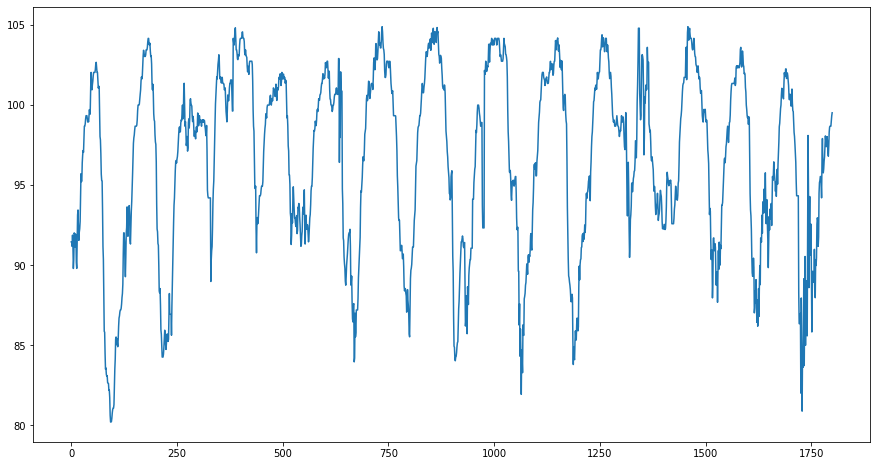

In [3]:
plt.figure(figsize=(15, 8))
plt.plot(hr_data)

plt.show()

## Scale Data

In [4]:
# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
x1 = s1.fit_transform(hr_data)


window = 120
X = []
Y = []

for i in range(window,len(x1)):
    X.append(x1[i-window:i,:])
    Y.append(x1[i,:])

X, Y = np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)
print(X.shape, Y.shape)

(1680, 120, 1) (1680, 1)


## Split Data to Train and Test data

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1344, 120, 1) (336, 120, 1) (1344, 1) (336, 1)


# Consider Models by Changing the Number of Units and Drop rates

## **Part One :** Comparision Between Units Sizes

In [ ]:
unitss = [10, 100, 200, 300, 400, 500]
drop_rate = .5
models = dict()

for units in unitss:
    # print(f'units = {units}, drop rate = {drop_rate}')
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(drop_rate))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(drop_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(drop_rate))
    model.add(Dense(units=1))
    model.compile(optimizer = "adam", loss = "mse", metrics = ['accuracy'])
    es = EarlyStopping(monitor='loss', mode='min', verbose=0, patience=10)
    history = model.fit(x_train, y_train, epochs = 1000, batch_size = 240, callbacks=[es], verbose=0)

    models[f'u{units}d{drop_rate}'] = [model, history]
    model.save(f'models/model-u{units}d{drop_rate}.h5')

## **Part Two :** Comparision Between Drop rate Sizes

In [ ]:
units = 100
drop_rates = [.1, .2, .3, .4, .6, .7, .8, .9]

for drop_rate in drop_rates:
    # print(f'units = {units}, drop rate = {drop_rate}')
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(drop_rate))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(drop_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(drop_rate))
    model.add(Dense(units=1))
    model.compile(optimizer = "adam", loss = "mse", metrics = ['accuracy'])
    es = EarlyStopping(monitor='loss', mode='min', verbose=0, patience=10)
    history = model.fit(x_train, y_train, epochs = 1000, batch_size = 240, callbacks=[es], verbose=0)

    models[f'u{units}d{drop_rate}'] = [model, history]
    model.save(f'models/model-u{units}d{drop_rate}.h5')

## Save Histories

In [ ]:
for name, item in models.items():
    histo = item[1]
    hist_df = pd.DataFrame(histo.history)
    with open('histories/json/'+name+'.json', mode='w') as address:
        hist_df.to_json(address)

    with open('histories/csv/'+name+'.csv', mode='w') as address:    
        hist_df.to_csv(address)

## Load Models and Histories
made in previous

In [65]:
models2 = dict()
names = []
import os
for _, _, file_names in os.walk("histories/csv"):
    for file_name in file_names:
        names.append(file_names[:-4])

h_address = "histories/csv/"
m_address = "models/model-"

for name in names:
    temp_model = load_model(m_address+name+'.h5')
    temp_history = pd.read_csv(h_address+name+".csv")
    models2[name] = [temp_model, temp_history]

## Make Predictions

In [66]:
predicts = dict()
for name, item in models.items():
    y_hat = item[0].predict(x_test)
    y_pred = s1.inverse_transform(y_hat)
    predicts[name] = y_pred

## Diagrams (Part One)
change the number of units

### main data vs predicted(red)

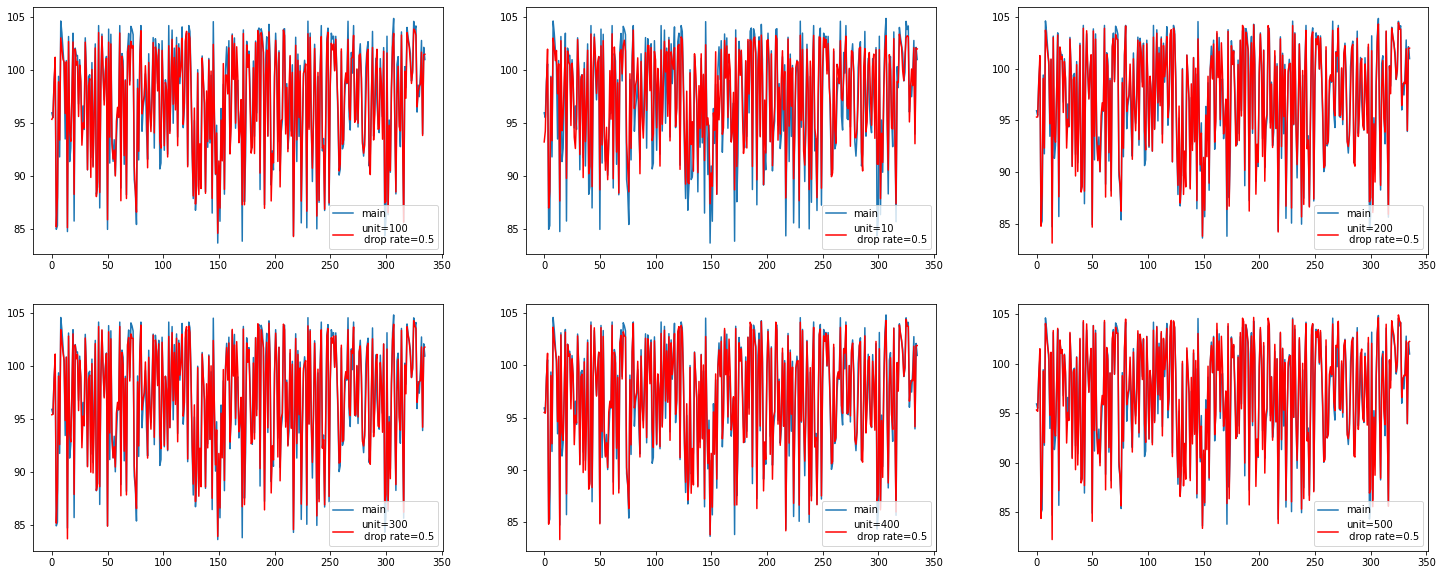

In [68]:
plt.figure(figsize=(25, 10))
i = 0

for name, y_pred in predicts.items():
    if "0.5" in name:
        i += 1
        plt.subplot(2, 3, i)
        plt.plot(s1.inverse_transform(y_test), label="main")
        temp = "unit=" + name[1:-4] + "\n drop rate=0.5"
        plt.plot(y_pred, label=temp, color='red')
        plt.legend()

plt.show()

### difference main data and predicted

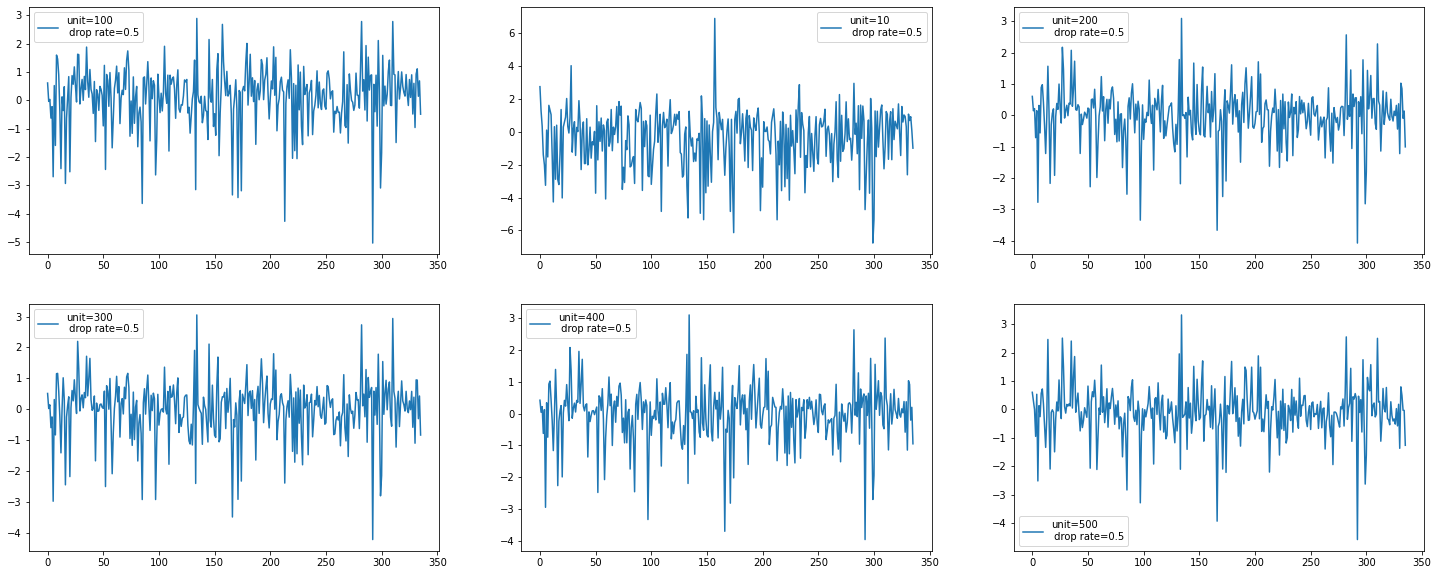

In [70]:
plt.figure(figsize=(25, 10))
i = 0

for name, y_pred in predicts.items():
    if "0.5" in name:
        i += 1
        plt.subplot(2, 3, i)
        temp = "unit=" + name[1:-4] + "\n drop rate=0.5"
        plt.plot(s1.inverse_transform(y_test)-y_pred, label=temp)
        plt.legend()

plt.show()

## losses

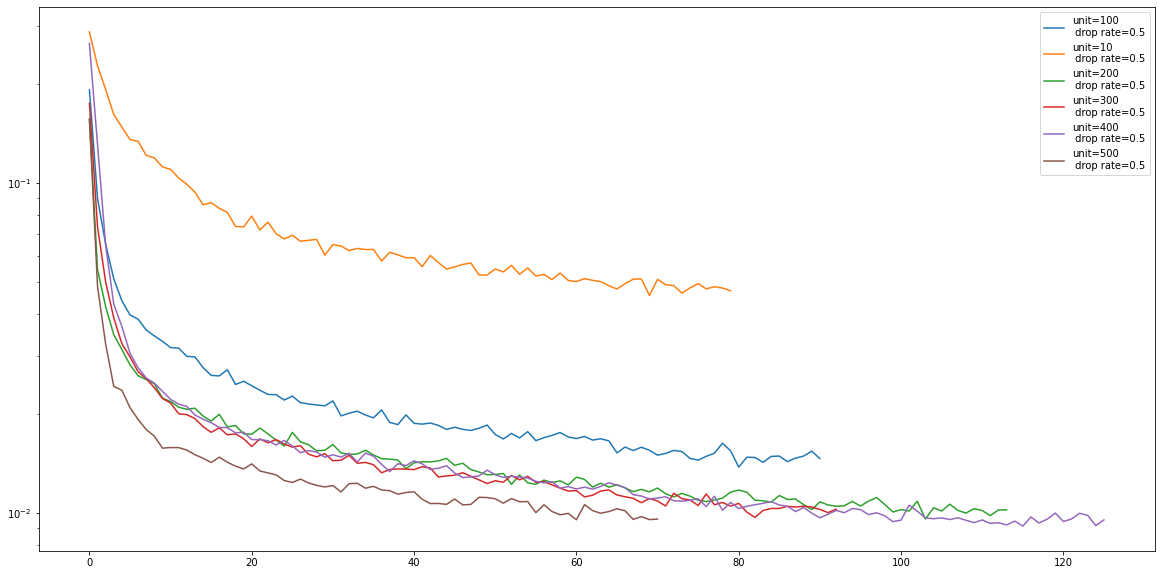

In [73]:
plt.figure(figsize=(20, 10))
for name, y_pred in predicts.items():
    if "0.5" in name:
        temp = "unit=" + name[1:-4] + "\n drop rate=0.5"
        plt.semilogy(models[name][1].history['loss'], label=temp)

plt.legend()

plt.show()

result: by ascending the number of units loss is descending, but it takes many times in "units=500"

## Diagrams (Part Two)
change the drop rates

### main data vs predicted(red)

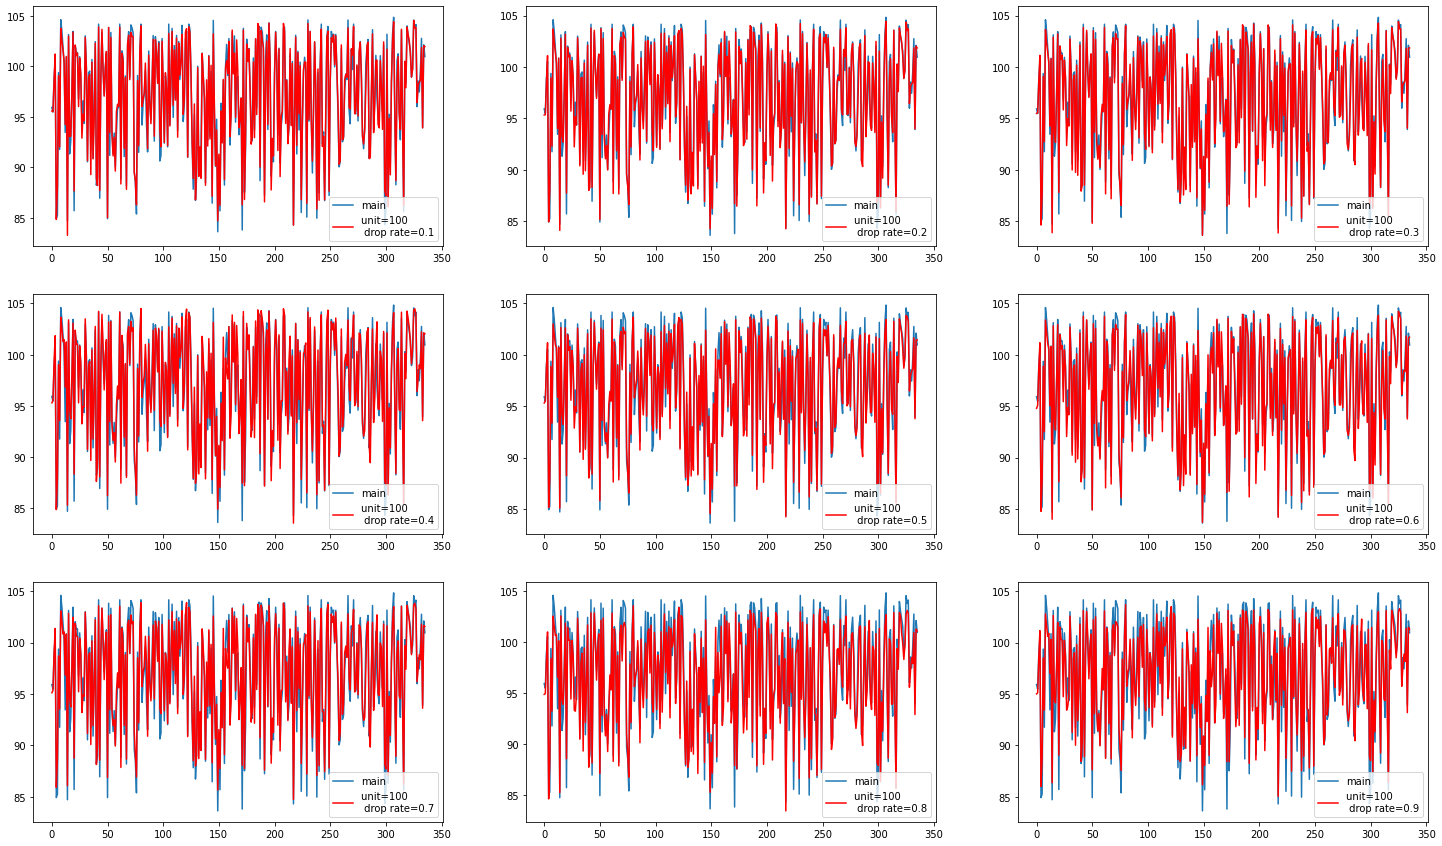

In [40]:
plt.figure(figsize=(25, 15))
i = 0

for name, y_pred in predicts.items():
    if "u100" in name:
        i += 1
        plt.subplot(3, 3, i)
        plt.plot(s1.inverse_transform(y_test), label="main")
        temp = "unit=100 \n drop rate=" + name[-3:]
        plt.plot(y_pred, label=temp, color='red')
        plt.legend()

plt.show()

### difference main data and predicted

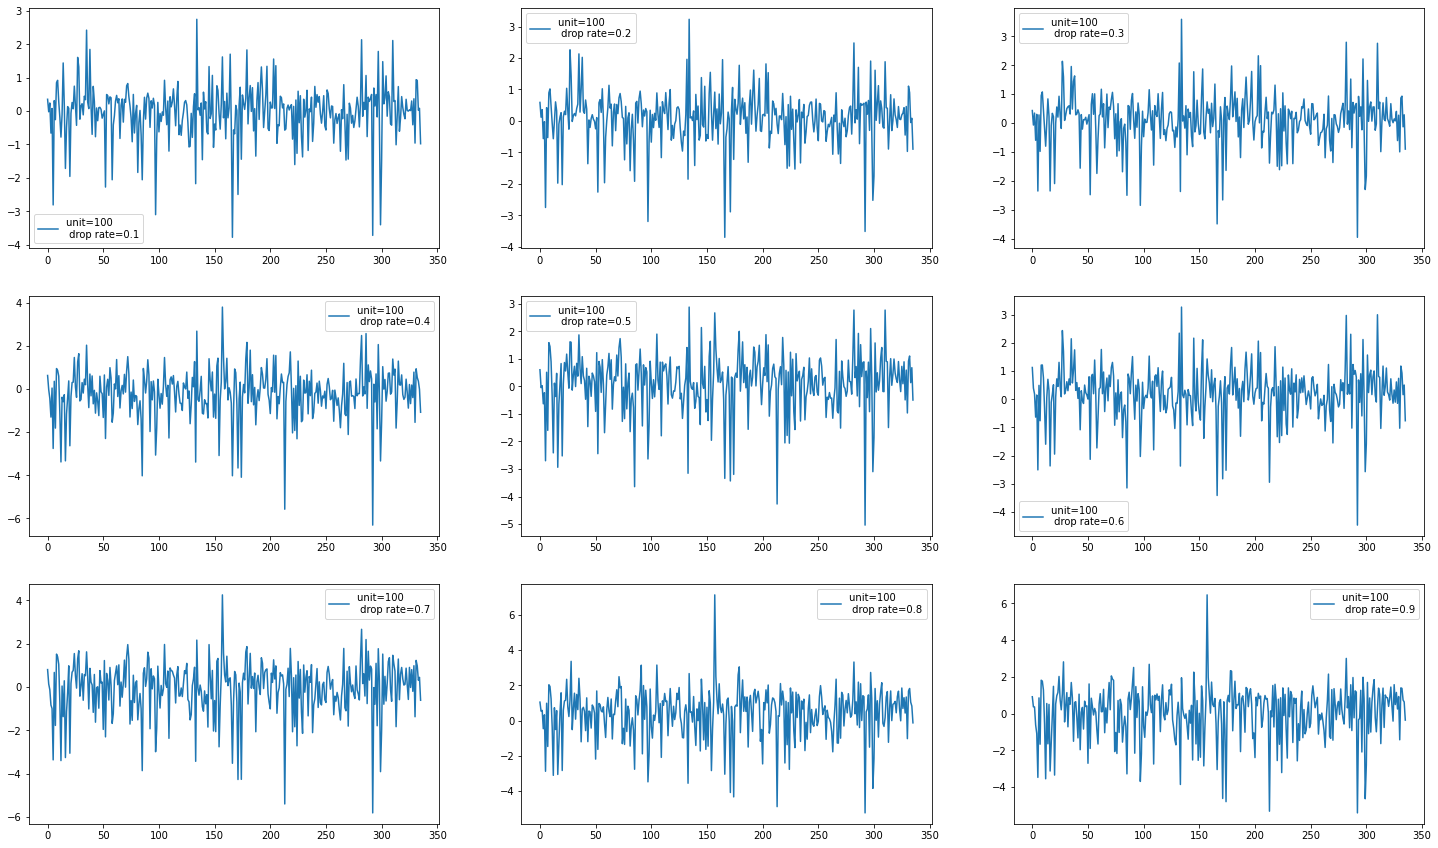

In [42]:
plt.figure(figsize=(25, 15))
i = 0

for name, y_pred in predicts.items():
    if "u100" in name:
        i += 1
        plt.subplot(3, 3, i)
        temp = "unit=100 \n drop rate=" + name[-3:]
        plt.plot(s1.inverse_transform(y_test)-y_pred, label=temp)
        plt.legend()

plt.show()

## losses

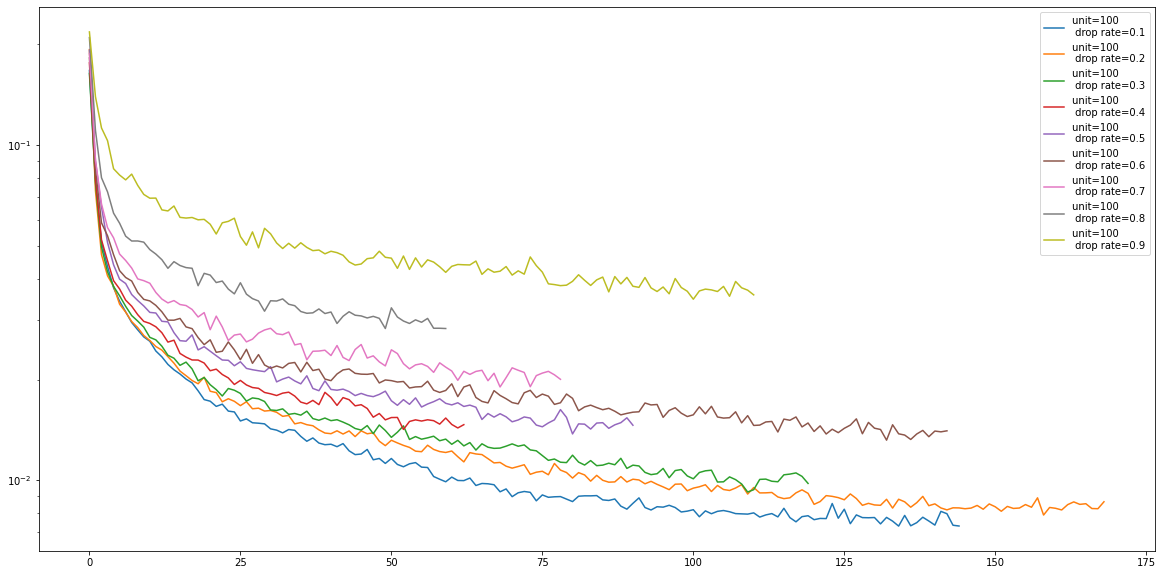

In [74]:
plt.figure(figsize=(20, 10))
for name, y_pred in predicts.items():
    if "u100" in name:
        temp = "unit=100 \n drop rate=" + name[-3:]
        plt.semilogy(models[name][1].history['loss'], label=temp)

plt.legend()

plt.show()

result: by ascending the drop rate loss is ascending too

**main result :**
by considering the time, model with "units=100" and "drop rate=0.1" is better than the other ones.

در حالت اول تعداد یونیت ها متغیر بود و بین این حالات تعداد یونیت برابر 100 با توجه به زمان مناسب تر بود
و در حالت دوم دراپ ریت ها متغیر بود و بین این حالات 0.1 از بقیه مناسب تر بود